In [7]:
%pylab inline
import octopus
from pygadgetreader import readsnap
import biff


Populating the interactive namespace from numpy and matplotlib


In [8]:
pos_cm_LMC, vel_cm_LMC, a, b = octopus.orbit('../../data/ICs/LMC/LMC1-97k/', 'LMC1_97K_vir', 0, 100, 97000, 0.1)

Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DM    

In [9]:
rcm_LMC = np.sqrt(pos_cm_LMC[:,0]**2 + pos_cm_LMC[:,1]**2 + pos_cm_LMC[:,2]**2)

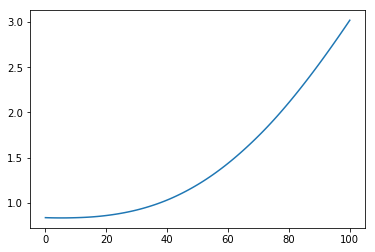

In [10]:
plot(rcm_LMC)

In [11]:
pos_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'pos', 'dm')
vel_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'vel', 'dm')
mass_LMC = readsnap('../../data/ICs/LMC/LMC1-97k/LMC1_97K_vir_000', 'mass', 'dm')

Returning DM    Positions
Returning DM    Velocities
Returning DM    Mass


In [12]:
S0, T0 = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC.astype(double)), mass_LMC.astype(double), 10, 10, 3)

## Off center effect on the BFE expansion

In [13]:
def re_center(pos, cm):
    for i in range(3):
        pos[:,i] = pos[:,i] - cm[i]
    return pos

pos_LMC_centered = re_center(pos_LMC, pos_cm_LMC[0])
octopus.CM(pos_LMC_centered,  vel_LMC)
S0_cm, T0_cm = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_centered.astype(double)), mass_LMC.astype(double), 10, 10, 3)

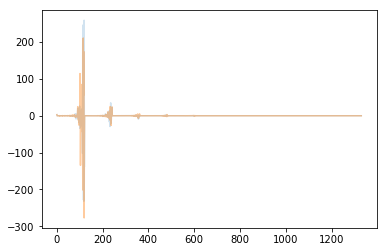

In [14]:
plot(S0.flatten(), alpha=0.2)
plot(S0_cm.flatten(), alpha=0.4)

In [15]:
## conclusion: There is effect due to the CM ! 

# truncation radii on the BFE expansion coefficients

In [16]:
def trunc_radii(pos,  r_t):
    pos_r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2) 
    len(pos_r)
    index = np.where(pos_r < r_t)
    return pos[index]

In [17]:
pos_LMC_trunc = trunc_radii(pos_LMC_centered, 10)

In [18]:
S0_tr, T0_tr = biff.compute_coeffs_discrete(np.ascontiguousarray(pos_LMC_trunc.astype(double)), mass_LMC.astype(double), 10, 10, 3)

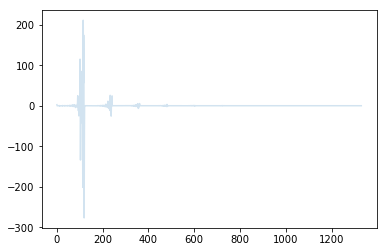

In [19]:
plot(S0_tr.flatten(), alpha=0.2)


## conclusion: Not much effect due to the truncation radii